# Antutu benchmark on Android

The goal of this experiment is to run benchmarks on a hikey960 board running Android with an IPA kernel and collect results. The analysis phase will consist in comparing IPA summary with:
    
The benchmark we will be using is ***Antutu 3Dbench*** (http://www.antutu.com/en). You will need to **manually install** the app on the Android device in order to run this Notebook.

the goals of this notebook:
1. Check different thermal behaviour for different workload or configuration
1. Compare the real power usage of SOC for different workload or configuration.


In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2018-05-09 13:46:14,500 INFO    : root         : Using LISA logging configuration:
2018-05-09 13:46:14,501 INFO    : root         :   /home/steven/lisa/lisa-github/logging.conf


In [2]:
%pylab inline

import copy
import os
from time import sleep
from subprocess import Popen
import pandas as pd

# Support to access the remote target
import devlib
from env import TestEnv

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


## Test environment setup

For more details on this please check out **examples/utils/testenv_example.ipynb**.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in `my_target_conf`. Run `adb devices` on your host to get the ID. Also, you have to specify the path to your android sdk in ANDROID_HOME.

In [5]:
# Setup a target configuration
androidsdk_path=os.path.join(os.getcwd(), "../../../android-sdk")

my_target_conf = {
    
#     # Target platform and board
#     "platform"    : 'android',

#     # Add target support
#     "board" : 'pixel',
    
#     # Device ID
#     "device" : "HT6670300102",
    
#     "ANDROID_HOME" : "/home/vagrant/lisa/tools/android-sdk-linux/",
    
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : androidsdk_path,
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },
    
    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "sched_switch",
            "cpu_capacity",
            "cpu_frequency",
            "thermal_power_devfreq_limit",
            "thermal_power_devfreq_get_power",
            "thermal_power_cpu_limit",
            "thermal_power_cpu_get_power",
            "thermal_zone_trip",
            "cdev_update",
            "thermal_temperature",
            "thermal_power_allocator_pid",
            "thermal_power_allocator",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset'],
    
    # Define devlib modules to load
    "modules"     : [
        'cpufreq'       # enable CPUFreq support
    ],
    "results_dir" : "Android_Antutu2",

}

In [6]:
my_tests_conf = {

    # Folder where all the results will be collected
    # Platform configurations to test
    "confs" : [
        {
            "tag"            : "antutu",
            "flags"          : "ftrace",           # Enable FTrace events
            "sched_features" : "ENERGY_AWARE",     # enable EAS
        },
    ],
}

In [7]:
# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

2018-05-09 13:46:43,931 INFO    : TestEnv      : Using base path: /home/steven/lisa/lisa-github
2018-05-09 13:46:43,933 INFO    : TestEnv      : Loading custom (inline) target configuration
2018-05-09 13:46:43,934 INFO    : TestEnv      : Loading custom (inline) test configuration
2018-05-09 13:46:43,936 INFO    : TestEnv      : External tools using:
2018-05-09 13:46:43,938 INFO    : TestEnv      :    ANDROID_HOME: /home/steven/lisa/lisa-github/ipynb/ipa/../../../android-sdk
2018-05-09 13:46:43,939 INFO    : TestEnv      :    CATAPULT_HOME: /home/steven/lisa/lisa-github/tools/catapult
2018-05-09 13:46:43,940 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
2018-05-09 13:46:43,942 INFO    : TestEnv      : Connecting Android target [0123456789ABCDEF]
2018-05-09 13:46:43,944 INFO    : TestEnv      : Connection settings:
2018-05-09 13:46:43,945 INFO    : TestEnv      :    {'device': '0123456789ABCDEF'}
2018-05-09 13:46:45,107 INFO    : TestEnv      : Initializi

## Support Functions

This set of support functions will help us running the benchmark using different CPUFreq governors.

In [20]:
def wait_for_cooling():
    print "wait for cooling"
    while True:
        temp=target.read_int('/sys/class/thermal/thermal_zone0/temp')
        print temp
        if temp < 60000:
            break
        sleep(5)
    print "cooling done, start test"

In [21]:
def set_test1():
    wait_for_cooling()
    target.cpufreq.set_all_governors('schedutil')
    target.execute('echo 65000 > /sys/class/thermal/thermal_zone0/trip_point_0_temp')
    print target.read_value('/sys/class/thermal/thermal_zone0/trip_point_0_temp')


def set_test2():
    wait_for_cooling()
    target.execute('echo 70000 > /sys/class/thermal/thermal_zone0/trip_point_0_temp')
    print target.read_value('/sys/class/thermal/thermal_zone0/trip_point_0_temp')


In [10]:
# CPUFreq configurations to test
confs = {
#     'performance' : {
#         'label' : 'prf',
#         'set' :  set_performance,
#     },
    #'powersave' : {
    #    'label' : 'pws',
    #    'set' :  set_powersave,
    #},
#      'interactive' : {
#          'label' : 'int',
#          'set' :  set_interactive,
#      },
    'test1' : {
       'label' : 'test1',
       'set' :  set_test1,
    },
    'test2' : {
       'label' : 'test2',
       'set' :  set_test2,
    },
    #'ondemand' : {
    #    'label' : 'odm',
    #    'set' :  set_ondemand,
    #}
}

# The set of results for each comparison test
results = {}

In [23]:
#Check if PCMark si available on the device

def check_packages(pkgname):
    try:
        output = target.execute('pm list packages -f | grep -i {}'.format(pkgname))
    except Exception:
        raise RuntimeError('Package: [{}] not availabe on target'.format(pkgname))

# Check for specified PKG name being available on target
check_packages('com.antutu.ABenchMark')
target.adb_root(force=True)

In [12]:
from android import Screen

target.execute('am force-stop {}'.format("com.antutu.ABenchMark"))
target.execute('input keyevent 4')
Screen.set_orientation(target, auto=False, portrait=True)
Screen.set_brightness(target, auto=False, percent=0)
target.cpufreq.set_all_governors('schedutil')

# Start PCMark on the target device
#target.execute('monkey --pct-syskeys 0 -p com.antutu.ABenchMark -c android.intent.category.LAUNCHER 1')
# Wait few seconds to make sure the app is loaded
# Screen.set_orientation(target, auto=False, portrait=True)
#sleep(10)
#target.execute('input tap 961 202')
# Wait few seconds to make sure the app is loaded
# sleep(5)
    

# Run performance workload (assume screen is vertical)


2018-05-09 13:46:58,507 INFO    : Screen       : Force manual orientation
2018-05-09 13:46:58,509 INFO    : Screen       : Set orientation: PORTRAIT
2018-05-09 13:46:59,741 INFO    : Screen       : Set brightness: 0%


''

In [13]:
# Function that helps run a Antutu experiment
from android import Screen
from devlib.utils.android import adb_command

def benchmark_run(exp_dir):
    # Unlock device screen (assume no password required)
    target.execute('am force-stop {}'.format("com.antutu.ABenchMark"))
    target.execute('input keyevent 82')
    Screen.set_brightness(target, auto=False, percent=0)

    # Start PCMark on the target device
    target.execute('monkey --pct-syskeys 0 -p com.antutu.ABenchMark  1')
#     Screen.set_orientation(target, auto=False, portrait=True)

    # Wait few seconds to make sure the app is loaded
    sleep(5)
    
    # Flush entire log
    target.clear_logcat()
    target.execute('input tap 860 1000')
    sleep(1)
    Screen.set_orientation(target, auto=False, portrait=True)
    # Run performance workload (assume screen is vertical)
    target.execute('input tap 960 200')
    # Wait for completion (10 minutes in total) and collect log
#     log_file = os.path.join(exp_dir, 'log.txt')
    # Wait 5 minutes
    sleep(30)
    # Start collecting the log
#     with open(log_file, 'w') as log:
#         logcat = Popen(['adb logcat', 'com.antutu.ABenchMark.VirtualMachineState:*', '*:S'],
#                        stdout=log,
#                        shell=True)
#         # Wait additional two minutes for benchmark to complete
#         sleep(300)

#         # Terminate logcat
#         logcat.kill()

#     # Get scores from logcat
#     score_file = os.path.join(exp_dir, 'score.txt')
#     os.popen('grep -o ".*_SCORE .*" {} | sed "s/ = / /g" | sort -u > {}'.format(log_file, score_file))
    
    # Close application
    adb_command(target.adb_name, 'shell screencap -p /data/local/tmp/screen.png')
    adb_command(target.adb_name, 'pull /data/local/tmp/screen.png {}'.format(te.res_dir))
    target.execute('am force-stop com.antutu.ABenchMark')
    target.execute('am force-stop com.antutu.benchmark.full')

  

In [14]:
# Function that helps run PCMark for different governors

def experiment(governor, exp_dir):
    os.system('mkdir -p {}'.format(exp_dir));
    trace_file = os.path.join(exp_dir, 'trace.dat')

    logging.info('------------------------')
    logging.info('Run workload using %s governor', governor)
    confs[governor]['set']()

    ### Run the benchmark ###
    te.ftrace.start()

    benchmark_run(exp_dir)
    
    te.ftrace.stop()
    te.ftrace.get_trace(trace_file)

    # return all the experiment data
    return {
        'dir'        : exp_dir,
    }

## Run Antutu and collect scores

In [24]:
# Run the benchmark in all the configured governors
testresult_list=[]
for testname in confs:
    test_dir = os.path.join(te.res_dir, testname)
    res = experiment(testname, test_dir)
    testresult_list.append(test_dir)
    print test_dir

2018-05-09 14:01:29,479 INFO    : root         : ------------------------
2018-05-09 14:01:29,481 INFO    : root         : Run workload using test1 governor


wait for cooling
62357
57034
cooling done, start test
65000


2018-05-09 14:01:41,345 INFO    : Screen       : Set brightness: 0%
2018-05-09 14:01:48,022 INFO    : Screen       : Force manual orientation
2018-05-09 14:01:48,024 INFO    : Screen       : Set orientation: PORTRAIT
2018-05-09 14:02:43,712 INFO    : root         : ------------------------
2018-05-09 14:02:43,714 INFO    : root         : Run workload using test2 governor


/home/steven/lisa/lisa-github/results/Android_Antutu2/test1
wait for cooling
75663
71569
65632
63790
62357
61538
60924
60310
59900
cooling done, start test
70000


2018-05-09 14:03:29,143 INFO    : Screen       : Set brightness: 0%
2018-05-09 14:03:35,877 INFO    : Screen       : Force manual orientation
2018-05-09 14:03:35,879 INFO    : Screen       : Set orientation: PORTRAIT


/home/steven/lisa/lisa-github/results/Android_Antutu2/test2


After running the benchmark for the specified governors we can show and plot the scores:

In [25]:
map_label = {"00000000,000000f0": "big", "00000000,0000000f": "LITTLE"}
actor_order = ["GPU", "big", "LITTLE"]
runs = [("test1", os.path.join(te.res_dir, 'test1', 'trace.dat')), ("test2", os.path.join(te.res_dir, 'test2', 'trace.dat'))]

In [26]:
runs

[('test1',
  '/home/steven/lisa/lisa-github/results/Android_Antutu2/test1/trace.dat'),
 ('test2',
  '/home/steven/lisa/lisa-github/results/Android_Antutu2/test2/trace.dat')]

In [27]:
# te.ftrace.get_trace(te.res_dir)
te.ftrace.report(os.path.join(te.res_dir, 'test1', 'trace.dat'), os.path.join(te.res_dir, 'test1', 'trace.txt'))
te.ftrace.report(os.path.join(te.res_dir, 'test2', 'trace.dat'), os.path.join(te.res_dir, 'test2', 'trace.txt'))

In [28]:
!tree {te.res_dir}

/home/steven/lisa/lisa-github/results/Android_Antutu2
├── screen.png
├── test1
│   ├── trace.dat
│   └── trace.txt
└── test2
    ├── trace.dat
    └── trace.txt

2 directories, 5 files


In [30]:
testresult_list

['/home/steven/lisa/lisa-github/results/Android_Antutu2/test1',
 '/home/steven/lisa/lisa-github/results/Android_Antutu2/test2']

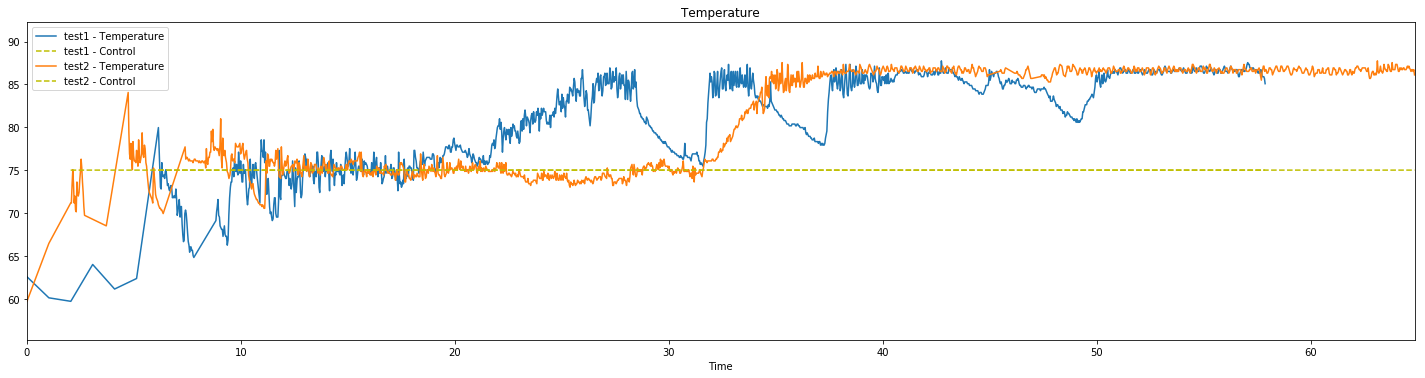

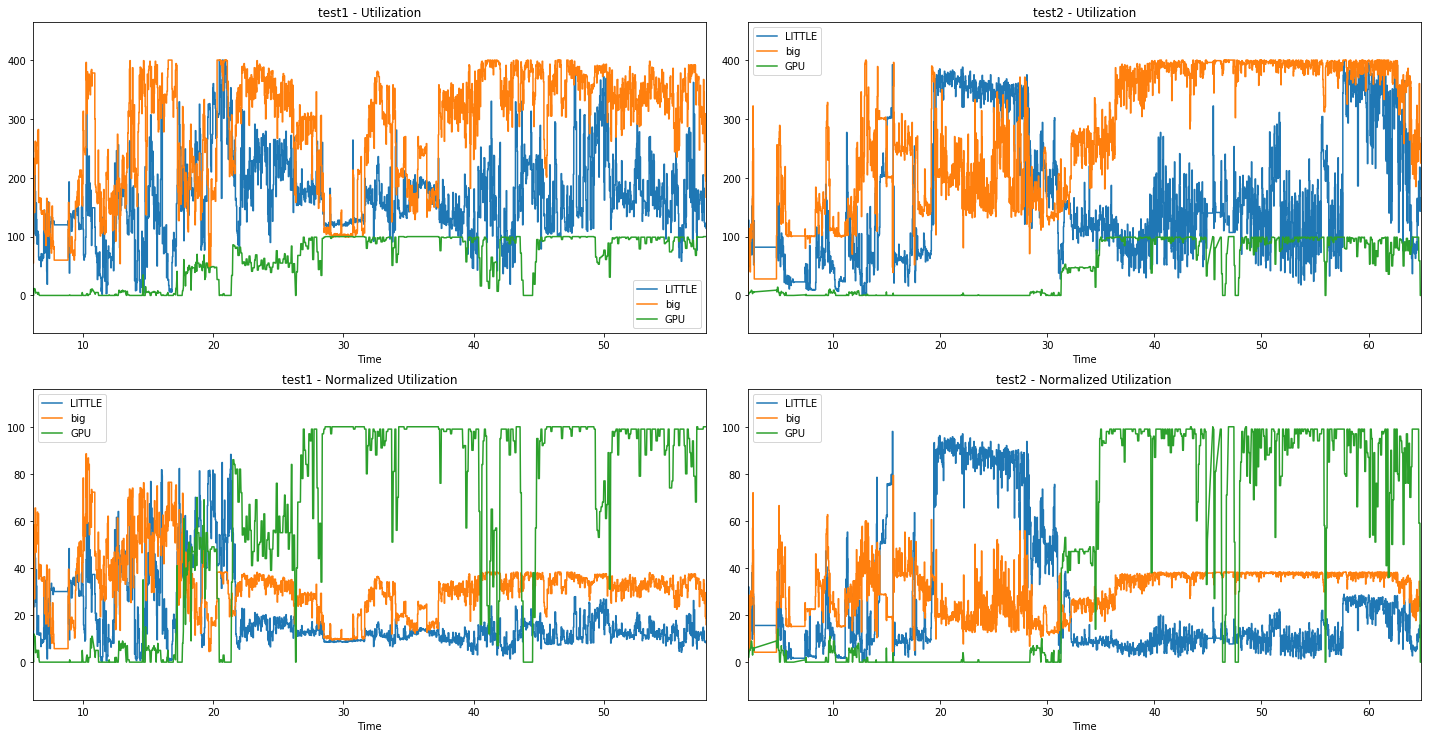

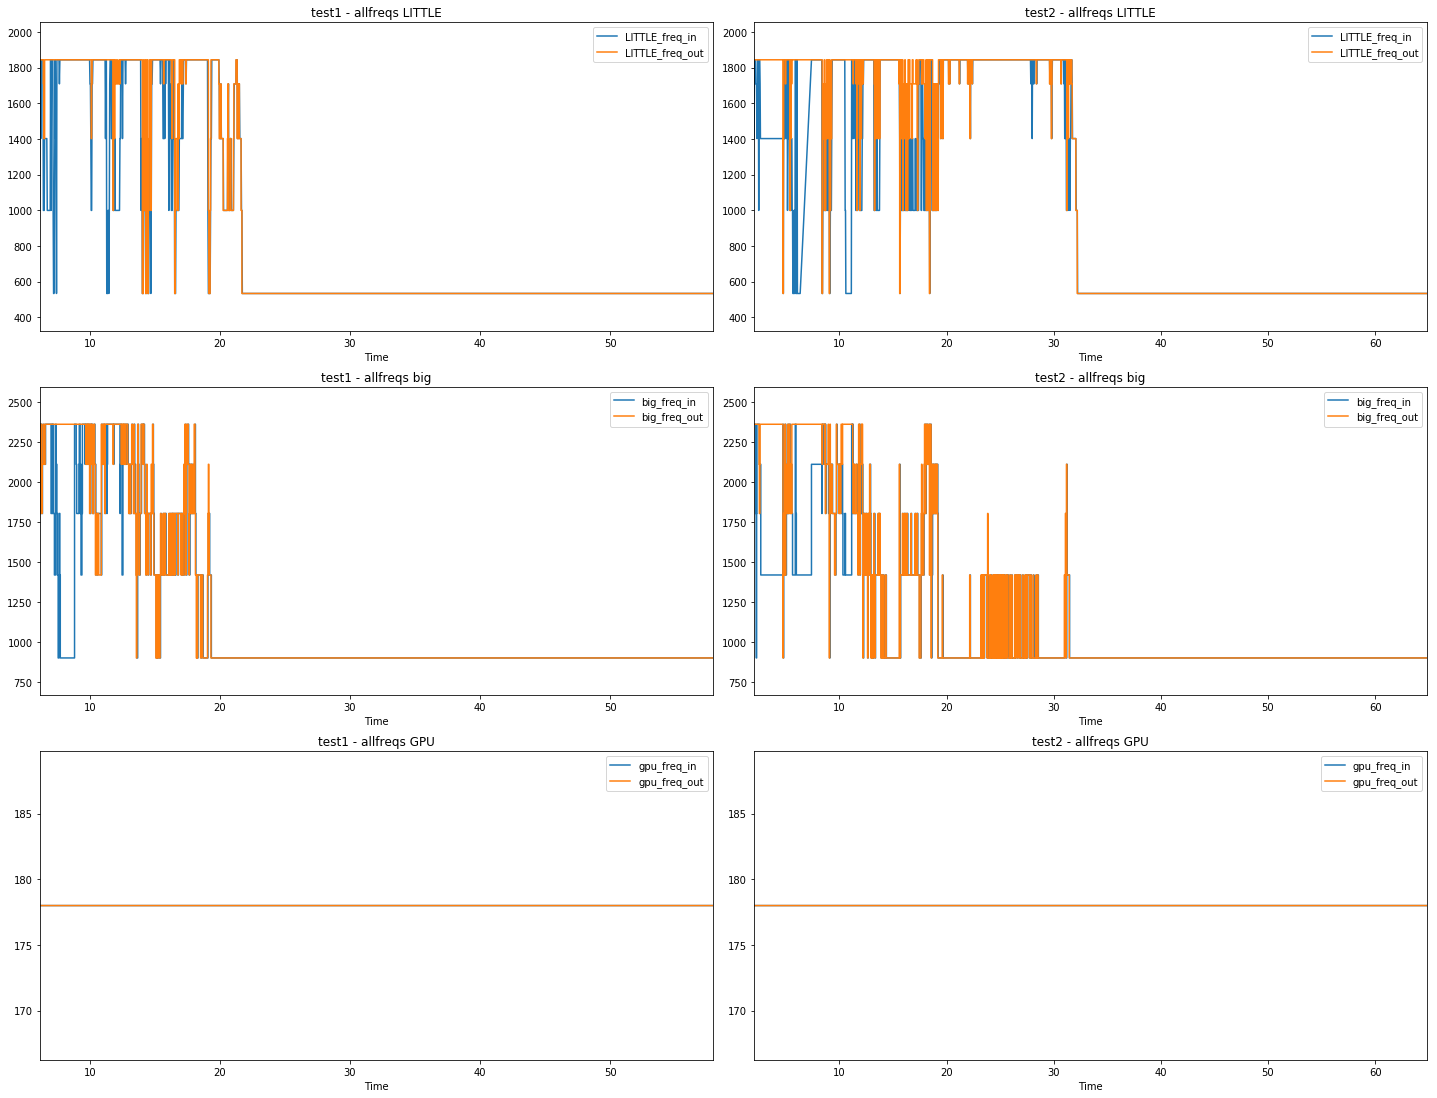

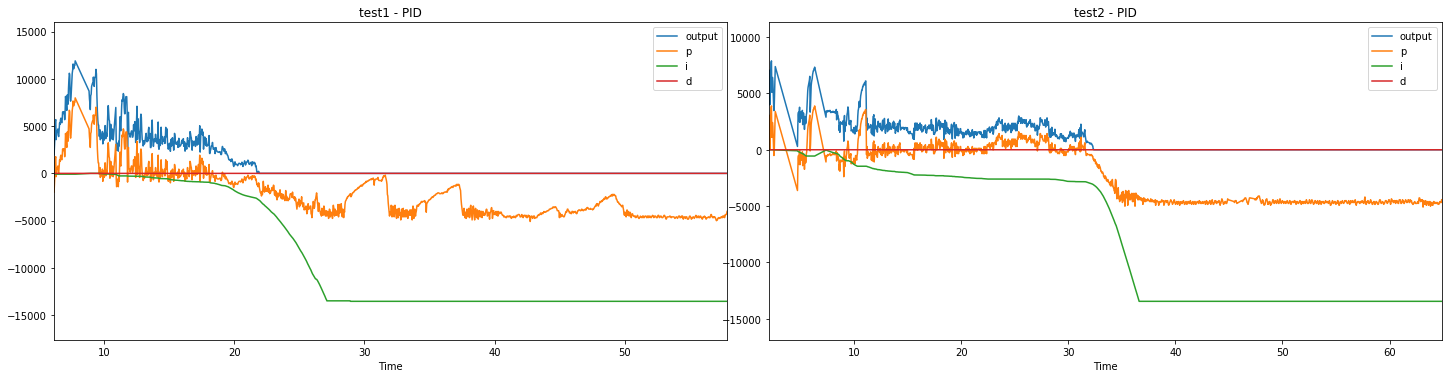

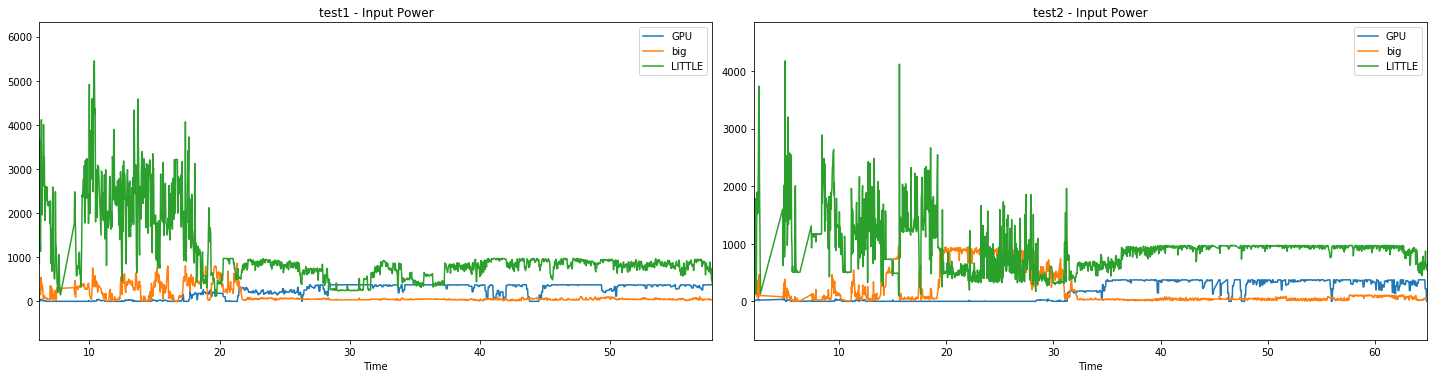

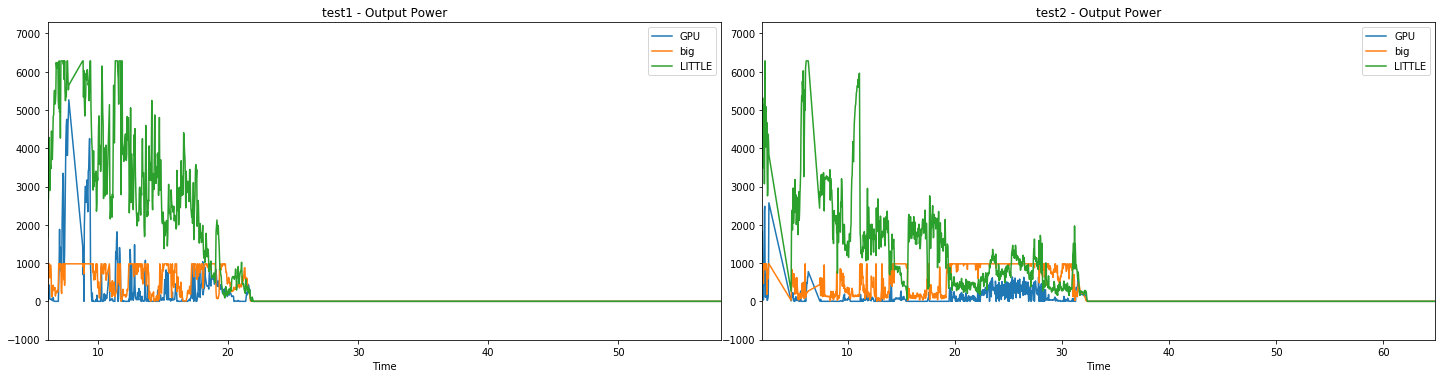

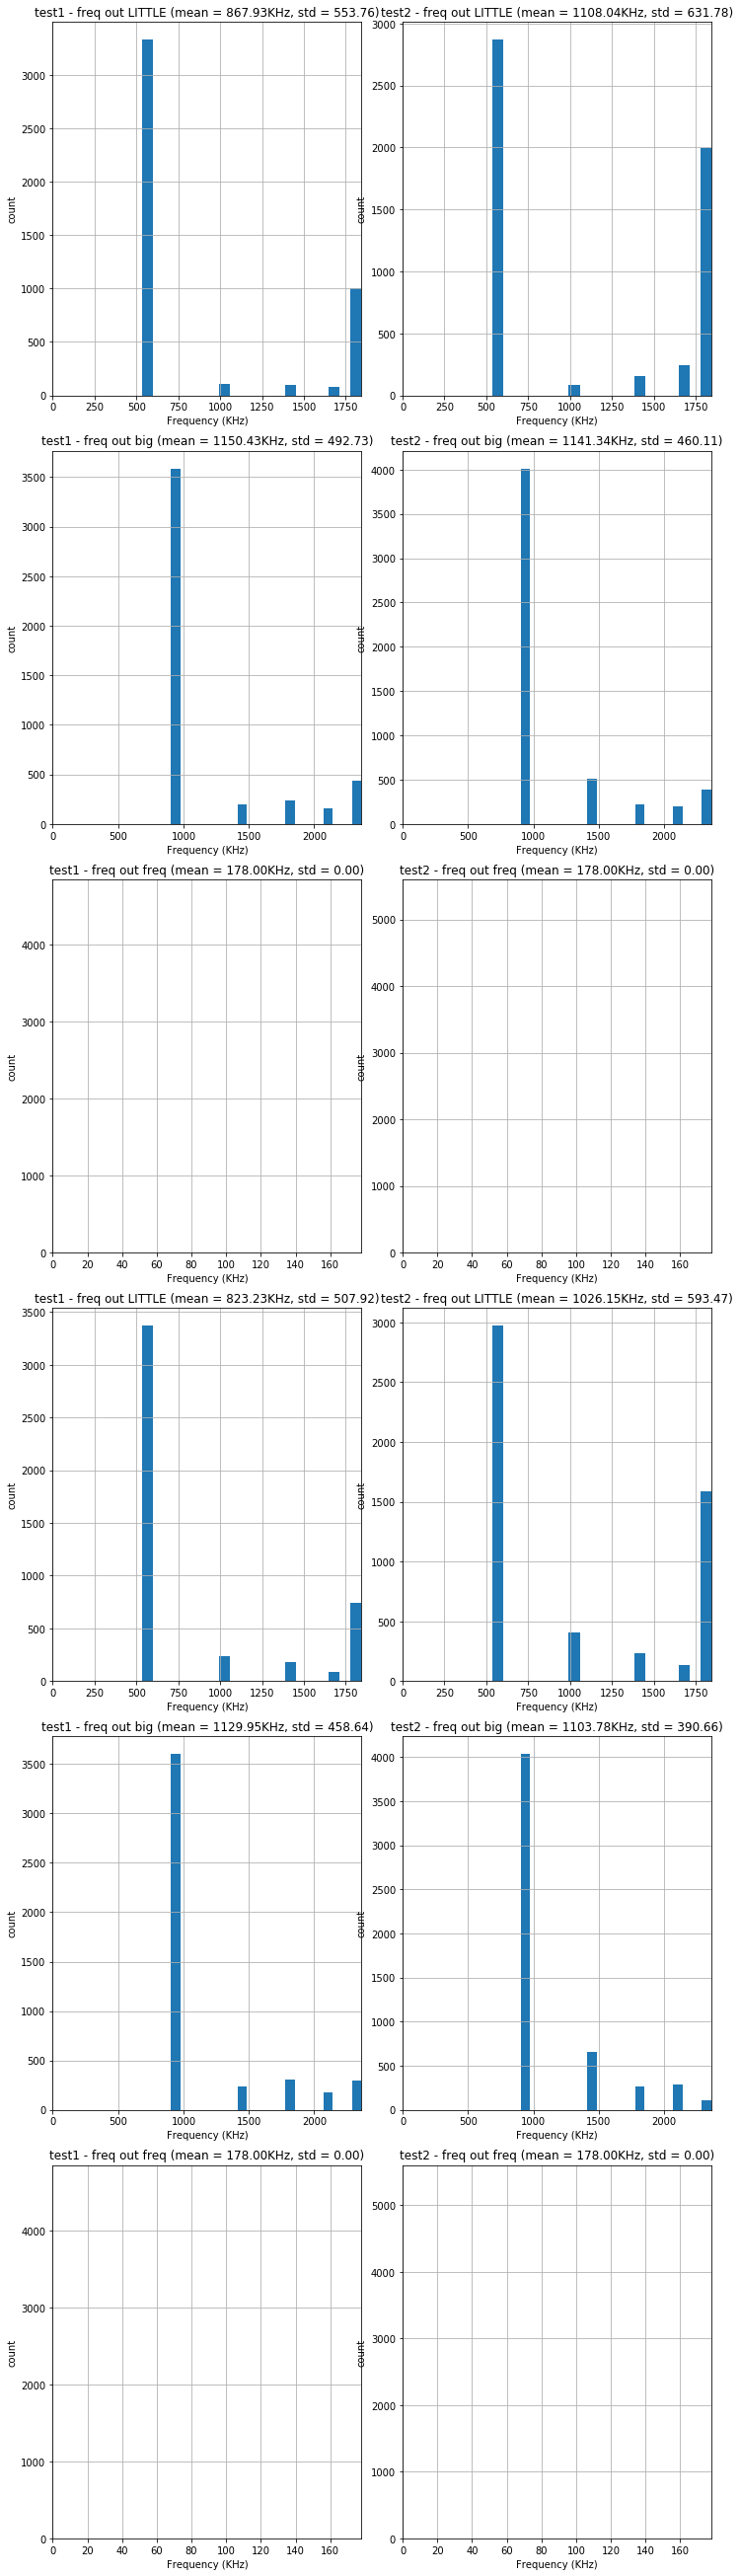

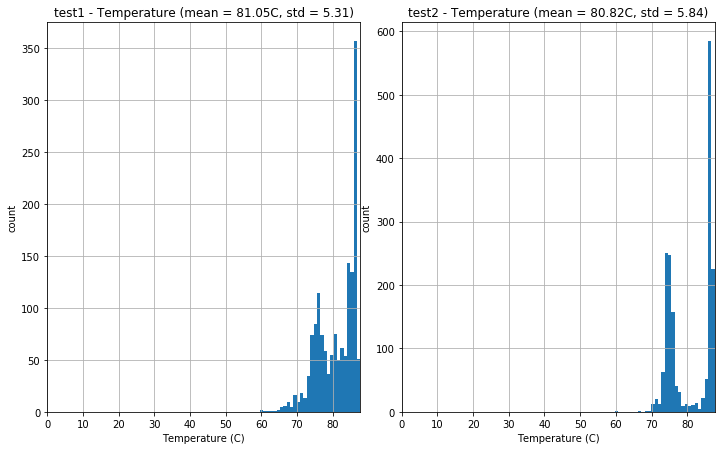

In [29]:
trappy.compare_runs(actor_order, map_label, runs)

In [33]:
target.execute('am force-stop com.antutu.ABenchMark')
target.execute('am force-stop com.antutu.benchmark.full')

''